In [1]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
import os
from plotly import graph_objects as go
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)



%load_ext autoreload

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

In [24]:
df_orig = pd.read_csv("data-processed/rki-reports.csv")
# df = pd.read_csv("data-processed/data_rki_prepared.csv")
df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df['date']=df['date'].astype('datetime64[ns]')
df.index = df.date

In [16]:
l = 'Bremen'
column = 'confirmed'
peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
df.loc[(df.index.isin(peak_index)) & (df.land == l), column]

date
2020-03-04      3.0
2020-04-19    585.0
Name: confirmed, dtype: float64

In [28]:

df['date'] = df['date'].astype('datetime64[ns]')
df.index = df.date

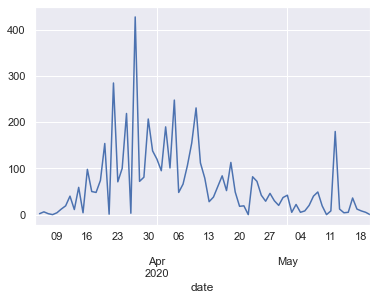

In [18]:
df_ham['confirmed_change'].plot()

In [151]:
df.land.unique()


array(['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hesse', 'Lower Saxony',
       'Mecklenburg-Western Pomerania', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony', 'Saxony-Anhalt',
       'Schleswig-Holstein', 'Thuringia', nan], dtype=object)

In [175]:
def findpeak_trend(df):
    df_peak_log = df.loc[:, ['confirmed_peak_log']].dropna()
    
    from sklearn.linear_model import LinearRegression
    days_pred_start = 10  # for how long to draw  the trend
    days_since_first_peak_start = 7  # how many days to wait since the first outbreak before estimating trend
    days_other_peak_starts = 7  # how many days since the second+ outbreak should pass before calculating trend

    # is we do not have enough data then exit
    if len(df.loc[:, ['confirmed_peak_log']].dropna()) < days_since_first_peak_start:
        df['peak_log_trend'] = np.NaN
        return df
    # find all indixes of outbreak beginnings
    peak_indixes = df.loc[df.confirmed_peak_date == 1].index.tolist()
#     peak_indixes[0] = df_peak_log.index.min()
    
    print(peak_indixes)

    # iterate over peak indixes
    for i, index in enumerate(peak_indixes):
        peak_index = peak_indixes[i]
        days_pred = days_pred_start
        if i == 0:
            # select y values since the beginning of the outbreak till defined number of days
            # and take a 3 days moving average for a smother trend
            days_add = days_since_first_peak_start
#             if len(peak_indixes) > 1:
#                 if days_add < len(df.loc[peak_index:peak_indixes[i+1]]):
#                     days_add = len(df.loc[peak_index:peak_indixes[i+1]])
#             else:
#                 if days_add < len(df):
#                     days_add = len(df)
                    
                    
            print(days_add)
            
            y = df_peak_log.loc[df_peak_log.index < peak_index +
                       datetime.timedelta(days=days_add), 'confirmed_peak_log'].rolling(3).median().dropna()
        else:
            # for the second+ outbreak use different number of minimum required days
            days_add = days_other_peak_starts
            # exis if we do not have enough data for an estimation
            if len(df.loc[peak_index:peak_index + datetime.timedelta(days=days_add)]) < days_other_peak_starts:
                return df
            else:
                # if we have more data to estimate second peak then use all of it
                days_other_peak_starts = len(df.loc[peak_index:df.index.max()])
                # if enough data then select y for estimating the trend
                y = df_peak_log.loc[(df_peak_log.index < df_peak_log.index.max()) &
                           (df_peak_log.index > peak_index), 'confirmed_peak_log'].rolling(3).median().dropna()

        # calculate X as number of days in Y and reshape to fit in LogReg model
        X = (y.index - y.index[0]).days.values.reshape(-1, 1)
    
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        
        # train LogReg model
        reg = LinearRegression().fit(X, y)

        # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
        for days in [days_pred_start + i for i in [0, 10, 20, 35]]:
            X2 = (range(1, days + len(y)) + max(X)[0]).reshape(-1, 1)
            X2 = scaler.transform(X2)
            trend = reg.predict(X2)
            days_pred = days
            if min(trend) < 0:
                break
        
        

        # prepare y2 dataframe using index as a date range between the last date of y+1
        # and last date of y+days_estimated_for
        y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                                 y.index.max() + datetime.timedelta(days=days_pred))
        y2 = pd.DataFrame(index=y2_index, data=trend, columns=['peak_log_trend'])
        
        # remove extra negative values (if exist) except the first one (for clarity)
        try:
            first_negative_val = y2.loc[y2.peak_log_trend < 0].index[0]
            y2 = y2.loc[y2.index <= first_negative_val, 'peak_log_trend']
        except:
            pass
        # in case its the first peak simply merge DFs
        if i == 0:
            df = df.join(y2, how='outer')
        # otherwise merge and make sure that we fit all trends in the same column for easy plotting
        else:
            df = pd.merge(df, y2, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
            df['peak_log_trend'] = df.loc[:, ['peak_log_trend_x', 'peak_log_trend_y']].apply(
                lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
            df.drop(['peak_log_trend_x', 'peak_log_trend_y'], axis=1, inplace=True)

    return df

In [ ]:
df_ham = df.loc[df.land == 'Rhineland-Palatinate']
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = findpeak_trend(df_ham)
dd.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()

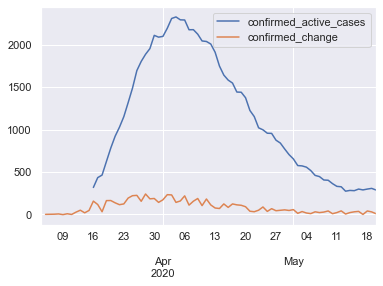

In [174]:
dd.loc[:, [ 'confirmed_active_cases', 'confirmed_change']].plot()

In [158]:
from fbprophet import Prophet
import datetime
import pandas as pd


def add_forecast_prophet(df_in, column, window=60, ):
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame(
        {'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day', inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast], axis=1)
    df_result[f'peak_log_trend'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]

    return df_result


In [89]:
dd2 = add_forecast_prophet(df_ham, 'confirmed_peak_log')

In [71]:
# dd2

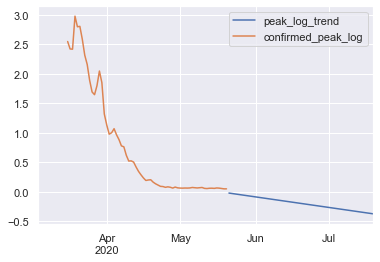

In [70]:
dd2.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()